# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with spatial patterns in certain seasons** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.12 ** <br>
** Last Update  : 2018.09.12 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. SST, SLP, z500). It aims to unveil the relation between the climatological fields and try to illustrate how the atmosphere responses to the change of ocean.
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/spatial/fields_only'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_fields_SFlux = Dataset(os.path.join(datapath_ERAI_fields,
                                                     'surface_ERAI_monthly_regress_1979_2016_extra.nc'))
    dataset_ERAI_500hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                               'pressure_500hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # geopotential height at 500hPa (m)
    z_500hPa_ERAI = dataset_ERAI_500hPa.variables['z'][:] / constant['g']
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # 3D fields [time, lat, lon]
    SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:]
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:]
    SST_ERAI_mask = np.ma.getmaskarray(SST_ERAI[0,:,:])
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:]
    SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    # instantaneous turbulent flux
    #SFlux_sensible_ERAI = dataset_ERAI_fields_SFlux.variables['ishf'][:] # W/m2
    #SFlux_latent_ERAI = dataset_ERAI_fields_SFlux.variables['ie'][:] * constant['Lv'] # W/m2
    # 3D fields [year, month, lat]
    AMET_0_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000
    # other dimensions
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    longitude_AMET_ERAI = dataset_ERAI_AMET.variables['longitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        #net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]

*********************** extract variables *************************


Table for an easy lead / lag analysis of seasonal data <br>

| -6 | -5 | -4 | -3 | -2 | -1 |winter| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|JJA |JAS |ASO |SON |OND |NDJ |DJF   |JFM |FMA |MAM |AMJ |MJJ |JJA |

| -6 | -5 | -4 | -3 | -2 | -1 |summer| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |JAS |ASO |SON |OND |NDJ |DJF |

In [ ]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! <br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag +1 : x[2:] & y[:-2]<br>
... <br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +6 : x[:-1] & y[1:] <br>

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   SST & z500  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 3 dimensions is regressed on another with the same dimensions.


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


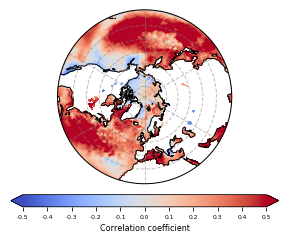

In [4]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   SST & z500  ======================')
    SST_season_series = meta.statistics.operator.seasons(SST_ERAI[:,:95,:],
                                                         span='DJF')
    stat_SST_ERAI = meta.statistics.operator(SST_season_series)
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=3, obj='detrend')
    z500_season_series = meta.statistics.operator.seasons(z_500hPa_ERAI[:,:,:95,:],
                                                         span='DJF', Dim_month=True)
    stat_z500_ERAI = meta.statistics.operator(z500_season_series)
    stat_z500_ERAI.anomaly(Dim_month=False)
    stat_z500_ERAI.detrend()
    stat_z500_ERAI.lowpass(window=3, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_SST_ERAI._lowpass,
                                                     stat_z500_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SST_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'sst_z500', 'season',
                                   'spatial_ERAI_SST_lag_{}_ERAI_z500_annual.png'.format(lag)))  

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   SST & SFlux  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 3 dimensions is regressed on another with the same dimensions.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


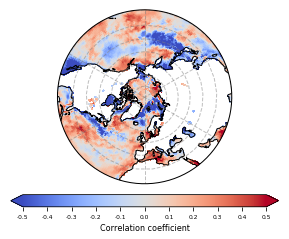

In [5]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   SST & SFlux  ======================')
    SST_season_series = meta.statistics.operator.seasons(SST_ERAI[:,:95,:],
                                                         span='DJF')
    stat_SST_ERAI = meta.statistics.operator(SST_season_series)
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=3, obj='detrend')
    SFlux_season_series = meta.statistics.operator.seasons(net_flux_surf_ERAI_area[:-1,:,:95,:],
                                                           span='DJF', Dim_month=True)
    stat_SFlux_ERAI = meta.statistics.operator(SFlux_season_series)
    stat_SFlux_ERAI.anomaly(Dim_month=False)
    stat_SFlux_ERAI.detrend()
    stat_SFlux_ERAI.lowpass(window=3, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_SFlux_ERAI._lowpass,
                                                     stat_SST_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SST_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'sst_SFlux', 'season',
                                   'spatial_ERAI_SFlux_lag_{}_ERAI_SST_annual.png'.format(lag)))  

Be cautious about the time across the year! <br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag +1 : x[2:] & y[:-2]<br>
... <br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +6 : x[:-1] & y[1:] <br>